In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
data = pd.read_csv("latest_binance_data.csv")
data = data.loc[:,['date','high','low','open','volume','close']]
data = data.set_index('date')
data.index = pd.to_datetime(data.index,unit='ns')
aim = 'close'
train_data = data.iloc[200:]
test_data = data.iloc[:200]

In [3]:
# Function to plot line graph
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Bitcoin/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

In [4]:
def normalise_zero_base(continuous):
    return continuous / continuous.iloc[0] - 1

In [5]:
# Function to extract window data
def extract_window_data(continuous, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(continuous) - window_len):
        tmp = continuous[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [6]:
# Prepare data
def prepare_data(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

In [7]:
# Build GRU model
def build_gru_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(GRU(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [8]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Prepare data
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.24
optimizer = 'adam'
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    data, aim, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [9]:
# Build and train the model with early stopping
model = build_gru_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), 
    epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True,
    callbacks=[early_stopping])

d:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0078 - val_loss: 0.0013
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 6.8790e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 7.4419e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 6.7694e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 3.9560e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 5.0231e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 5.0952e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 4.8406e-04


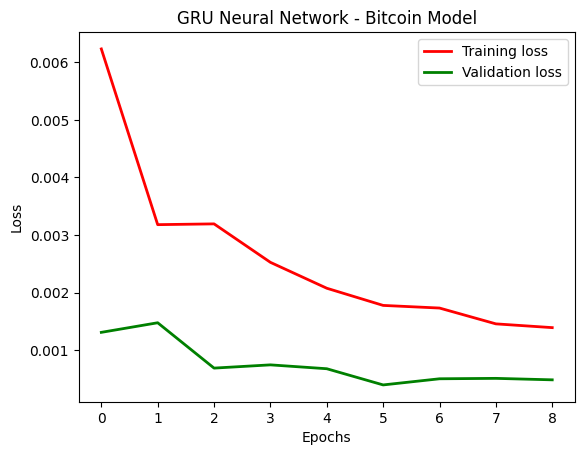

In [10]:
# Plot training and validation loss
plt.plot(modelfit.history['loss'], 'r', linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g', linewidth=2, label='Validation loss')
plt.title('GRU Neural Network - Bitcoin Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Evaluate the model
evaluation = model.evaluate(X_test, y_test)
print("Evaluation Loss:", evaluation)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1084e-04 
Evaluation Loss: 0.00048405895358882844


In [12]:
# Make predictions
preds = model.predict(X_test).squeeze()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [13]:
# Calculate mean absolute error
mae = mean_absolute_error(preds, y_test)

In [14]:
# Calculate mean squared error
mse = mean_squared_error(preds, y_test)

In [15]:
# Calculate R-squared score
r2 = r2_score(y_test, preds)

In [17]:
# Print evaluation metrics
print("Evaluation Metrics:")
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Evaluation Metrics:
Mean Absolute Error: 0.017532612654469492
Mean Squared Error: 0.000536938414528657
R-squared Score: 0.8393730312980566


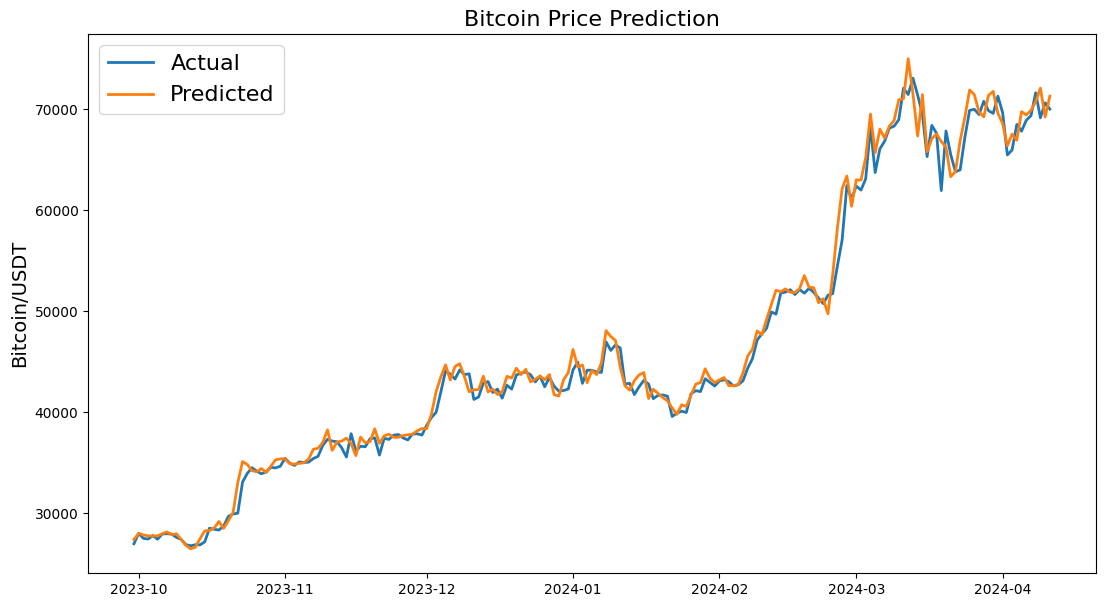

In [18]:
# Plot actual vs. predicted prices
targets = test_data[aim][window_len:]
preds = test_data[aim].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Actual', 'Predicted', title='Bitcoin Price Prediction')